In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = True
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

from util import er
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import tensorflow_probability as tfp
from scipy import stats
from sklearn import metrics

# Configuration
data_folder = '/app/data'

# Load data
data = er.load_data(data_folder)
data.sort_values(by='Triage', inplace=True);
data.reset_index(inplace=True);
data.drop(columns='index', inplace=True);

# Resource Scheduling

## Resource Scheduling

**As a second problem, we will consider scheduling the ER center operations**

* ER centers run with a limited resources (e.g. staff, rooms, medical equipment)
* Choosing _when to perform the activities_ can improve the center efficiency

**"Choosing when to do something" = scheduling**

We will consider a simplified form of the ER scheduling problem

* Scheduling decisions should be _revised over time_, as patients arrive
  * ...But we will solve the problem for _one time point only_
* Decisions are subject to _many types of constraints_
  * ...But we will consider _a small, representative subset_
* The activities to be performed for each patient are _not known in general_
  * ...But we will assume _they are provided_ by some kind of predictor

## The Dataset, Again

**Let's check again our dataset**

In [2]:
data.head()

,year,ID,Triage,TkCharge,Code,Outcome,Flow
0,2018,1,2018-01-01 00:17:33,2018-01-01 04:15:36,green,admitted,"[triage,visit,RX,visit]"
1,2018,2,2018-01-01 00:20:33,2018-01-01 03:14:19,green,admitted,"[triage,visit,lab,visit]"
2,2018,3,2018-01-01 00:47:59,2018-01-01 04:32:30,white,admitted,"[triage,visit,otolaryngological visit,visit]"
3,2018,51239,2018-01-01 00:49:51,NaT,white,abandoned,[]
4,2018,51241,2018-01-01 01:00:40,NaT,green,abandoned,[]


* We are interested in the individual patients (so, no binning)

**We cannot take into accont abandons (we do not know their activity flow)**

In [3]:
fdata = data[~data['TkCharge'].isnull()]

## Activity Flows

**Let's examine one activity flow**

In [5]:
fdata['Flow'].loc[6]

'[triage,visit,ultrasound,lab,RX,CT scan,visit,CT scan,visit]'

* Each "flow" is a string, listing the (historical) sequence of activities
* The first activity is always "triage", and takes place _at the arrival time_
  - As a consequence, we do not need to schedule "triage" activities
* The second and last activities are always visits
* Activities between pairs of "visit" can be performed in any sequence
  - The doctor prescribes some exams and treatments
  - These can be be performed in any order, before another visit

## Parsing Flows

**We need to convert flows into a more practical data structure**

In particular, we need to make explicit the existing precedence constraints:

```python
def flow_to_levels(fstring):
    activities = fstring[1:-1].split(',')
    levels = [[]]
    for a in activities:
        if a == 'triage': pass
        elif a == 'visit':
            if len(levels[-1]) == 0:
                levels[-1].append(a)
            else:
                levels.append([a])
            levels.append([])
        else:
            levels[-1].append(a)
    return levels[:-1]
```

## Parsing Flows

**First, we extract the activity names**

```python
def flow_to_levels(fstring):
    activities = fstring[1:-1].split(',')
    ...
```

**Then we loop over all the activities**

```python
def flow_to_levels(fstring):
    ...
    for a in activities:
        if a == 'triage': pass
        ....
```

* We do not process the "triage" activity
* ...Since when scheduling occurs it has already been performed

## Parsing Flows

**We parse each flow into a layered structure**

* Each layer (or level) contains activities that can be performed in any order
* Activities in contiguous levels are connected by precedence constraints

```python
def flow_to_levels(fstring):
    ...
    for a in activities:
        ...
        elif a == 'visit':
            ...
        else:
            ...
```

* Therefore, "visit" activities are have their own level
* ...And require some special treatment

## Parsing Flows

**When we encounter a "visit" activity:**

```python
def flow_to_levels(fstring):
    ...
    for a in activities:
        ...
        elif a == 'visit':
            if len(levels[-1]) == 0:
                levels[-1].append(a)
            else:
                levels.append([a])
            levels.append([])
        ...
```

* If the previous level is empty, we apppend the visit
* If the previous level is not empty, we append a new level with the visit
* In all cases, we prepare a new empty level

## Parsing Flows

**When we encounter any other activity we store it in the last level**

```python
def flow_to_levels(fstring):
    ...
    for a in activities:
        ...
        else:
            levels[-1].append(a)
```

**Add the end of the process we return all layers except the last**

```python
def flow_to_levels(fstring):
    ...
    return levels[:-1]
```

* The last level is always empty by construction

## Parsing Flows

**Let's parse a handful of flows and see the results**

In [8]:
npatients = 4
levels, codes_by_idx = {}, {}
for idx in fdata.index[:npatients]:
    levels[idx] = er.flow_to_levels(fdata.loc[idx]['Flow'])
    codes_by_idx[idx] = fdata.loc[idx]['Code']

levels[6]

[['visit'],
 ['ultrasound', 'lab', 'RX', 'CT scan'],
 ['visit'],
 ['CT scan'],
 ['visit']]

* Patients are identified by their index in the original `DataFrame`
* We also store the code for each patient

## Scheduling via CP/SAT

**The current state-of-the-art for scheduling is Constraint Programming**

...Or to be more precise a hybrid of CP and SMT called [Lazy Clause Generation](https://people.eng.unimelb.edu.au/pstuckey/COMP90046/resources/lazyj.pdf)

* LCG relies on a SAT engine for DPLL search and conflict extraction
* Some constraints are encoded directly into SAT formulas
* Other constraints have an attached propagator, CP-style
* The propagator can however also _explain failures_
  - I.e. provide a logical implication in case of failure
* Such explanations are used to build the implication graph

Overall, we have the versatility of CP, but much more reliable performance

## Determining the Horizon

**CP solvers (almost) always work with _finite domain variables_**

Before building any variable we need to determine a _horizon_ for our schedule

* The horizon must be larger than any possible schedule
* A frequent choice: summing all activity durations

**Indvidual durations can be obtained using this function**

```python
def get_dur(ttype):
    durs = {'visit': 1, 'ultrasound': 2, 'RX': 2}
    return durs[ttype] if ttype in durs else 4
```

* Our time unit will be 15 minutes
* We assume that a visit takes 1 unit
* A simple RX or ultrasound exam takes 2 units
* All other activities take 4

## Determining the Horizon

**The duration for a single patient can be obtained with:**

```python
def get_level_dur(levels):
    res = 0
    for lvl in levels: res += sum(get_dur(a) for a in lvl)
    return res
```

**..And finally all durations with:**

```python
def get_horizon(levels):
    eoh = sum(get_level_dur(l) for l in levels.values())
    return eoh
```

In [9]:
eoh = er.get_horizon(levels)
eoh

35

## Model and Variables

**We are going to use the [Google ortools](https://developers.google.com/optimization) CP/SAT solver**

* It's currently the best performing CP solver with a permissive license
* It provides a (reasonably) convenient Python interface
* The same suite offers also an LP solver (Glop) and wrappers for MIP solvers

**As in many of these tools, the first step is building a model object**

In [10]:
from ortools.sat.python import cp_model
mdl = cp_model.CpModel()

**Then, our first priority is _choosing the main decision variables_**

* We will introduce a _start_ and _end_ variable for each activity
* ...So that we can decide their location on the time axis

## Model and Variables

**We build all the variables for a single patient using:**

```python
import collections
Task = collections.namedtuple('task', 'start end interval ttype')

def levels_to_vars(mdl, levels, idx, tasks, last, rl, dl):
    for k, lvl in enumerate(levels):
        for i, a in enumerate(lvl):
            dur = get_dur(a)
            start = mdl.NewIntVar(rl, dl, f's_{idx}_{k}_{i}')
            end = mdl.NewIntVar(rl, dl, f'e_{idx}_{k}_{i}')
            interval = mdl.NewIntervalVar(start, dur, end, f'i_{idx}_{k}_{i}')
            tasks[(idx,k,i)] = Task(start, end, interval, a)
    last[idx] = Task(start, end, interval, a)
```

## Model and Variables

**For each activity, we:**

```python
...
def levels_to_vars(mdl, levels, idx, tasks, last, rl, dl):
    for k, lvl in enumerate(levels):
        for i, a in enumerate(lvl):
            dur = get_dur(a)
            start = mdl.NewIntVar(rl, dl, f's_{idx}_{k}_{i}')
            end = mdl.NewIntVar(rl, dl, f'e_{idx}_{k}_{i}')
            ...
    ...
```

* Extract the duration with `get_dur`
* Build a two integer variables, respectively for the start and end
* Both domains range from a _release date_ (i.e. `rl`) and a _deadline_ (i.e. `dl`)

## Model and Variables

**Additionally, we make use of _interval variables_**

```python
...
def levels_to_vars(mdl, levels, idx, tasks, last, rl, dl):
    for k, lvl in enumerate(levels):
        for i, a in enumerate(lvl):
            ...
            interval = mdl.NewIntervalVar(start, dur, end, f'i_{idx}_{k}_{i}')
    ...
```

An interval variable represents an _uninterrupted time span_

* It has a start, and end, and a duration
* All can be either existing decision variables, or fixed values
* In our case: start and end need to be decided, but the duration is fixed


## Model and Variables

**We store the variables in dictionaries**

...And use named tuples for convenience

```python
import collections
Task = collections.namedtuple('task', 'start end interval ttype')

def levels_to_vars(mdl, levels, idx, tasks, last, rl, dl):
    for k, lvl in enumerate(levels):
        for i, a in enumerate(lvl):
            ...
            tasks[(idx,k,i)] = Task(start, end, interval, a)
    last[idx] = Task(start, end, interval, a)
```

* The `tasks` dictionary is filled with all tasks
* The `last` dictionary contains the last task for each patient


## Model and Variables

**We build all problem variables with:**

```python
def add_all_vars(mdl, levels, rl, dl):
    tasks, last = {}, {}
    for idx, lvl in levels.items():
        levels_to_vars(mdl, lvl, idx, tasks, last, rl[idx], dl=dl[idx])
    return tasks, last
```

**Let's build all variables (assuming a 0 release date)**

In [12]:
rl, dl = {idx:0 for idx in levels}, {idx:eoh for idx in levels}
tasks, last = er.add_all_vars(mdl, levels, rl, dl)
last

{0: task(start=s_0_2_0(0..35), end=e_0_2_0(0..35), interval=i_0_2_0(start = s_0_2_0, size = 1, end = e_0_2_0), ttype='visit'),
 1: task(start=s_1_2_0(0..35), end=e_1_2_0(0..35), interval=i_1_2_0(start = s_1_2_0, size = 1, end = e_1_2_0), ttype='visit'),
 2: task(start=s_2_2_0(0..35), end=e_2_2_0(0..35), interval=i_2_2_0(start = s_2_2_0, size = 1, end = e_2_2_0), ttype='visit'),
 6: task(start=s_6_4_0(0..35), end=e_6_4_0(0..35), interval=i_6_4_0(start = s_6_4_0, size = 1, end = e_6_4_0), ttype='visit')}

## A First Solution Attempt

**Debugging declarative models can be difficult**

* So, it's a good idea to start making some tests as soon as possible
* For this reason, we will immediately try to solve our simple model

For this, we need to call:

```python
slv = cp_model.CpSolver()
status = slv.Solve(mdl)
```

* I.e. we build a `CpSolver` object
* ...Then we invoke the `Solve` method
* ...And then check the resulting status and solution

Of course, at this stage the solution will not be very meaningful

## A First Solution Attempt

**Let's see our first full program and the solution**

Since we are still debugging, we will consider only the first two patients

In [14]:
mdl = cp_model.CpModel()

levels, codes_by_idx = er.build_levels(fdata.iloc[:2])
eoh = er.get_horizon(levels)
rl, dl = {idx:0 for idx in levels}, {idx:eoh for idx in levels}
tasks, last = er.add_all_vars(mdl, levels, rl, dl)

slv = cp_model.CpSolver()
status = slv.Solve(mdl)
er.print_outcome(slv, levels, tasks, codes_by_idx, status)

Solver status: optimal, time(CPU sec): 0.00, objective: 0.0

0(green): visit(0-1), RX(0-2), visit(0-1)
1(green): visit(0-1), lab(0-4), visit(0-1)


* The format is `name(start-end)`
* The current decisions make no sense, since we are missing all constraints

## Precedence Constraints

**Once the variables are fine, it's time to _deal with the constraints_**

We will start from the precedence constraints:

```python
def add_precedences(mdl, levels, idx, tasks):
    for k, lvl in enumerate(levels[:-1]): # levels for a patient
        for i, _ in enumerate(lvl): # activities
            for j, _ in enumerate(levels[k+1]): # activities in next layer
                mdl.Add(tasks[idx,k,i].end <= tasks[idx,k+1,j].start)
```

* Each constraint is a simple inequality, i.e.: ${\rm end}_{idx,k,i} \leq {\rm start}_{idx,k,i}$

**We add all constraints with:**

```python
def add_all_precedences(mdl, levels, tasks):
    for idx, lvl in levels.items():
        add_precedences(mdl, lvl, idx, tasks)
```

## Testing the Precedence Constraints

**Let's test the effect of adding precedence constraints**

In [15]:
mdl = cp_model.CpModel()

levels, codes_by_idx = er.build_levels(fdata.iloc[:2])
eoh = er.get_horizon(levels)
rl, dl = {idx:0 for idx in levels}, {idx:eoh for idx in levels}
tasks, last = er.add_all_vars(mdl, levels, rl, dl)
er.add_all_precedences(mdl, levels, tasks)

slv = cp_model.CpSolver()
status = slv.Solve(mdl)
er.print_outcome(slv, levels, tasks, codes_by_idx, status)

Solver status: optimal, time(CPU sec): 0.00, objective: 0.0

0(green): visit(0-1), RX(1-3), visit(9-10)
1(green): visit(0-1), lab(1-5), visit(9-10)


* Precedence relations are respected, bu the start times are unnecessarily large
* ...That's because we haven't told the model that early scheduling is a good idea

## Cost Function

**For now, we will use the schedule _makespan_ as a cost function**

The makespan is simply _the end time of the last task_ in the schedule

```python
def add_makespan_variables(mdl, levels, codes_by_idx, last, eoh):
    codes = ['red', 'yellow', 'green', 'white']
    last_by_code = {c: [] for c in codes}
    for idx in levels.keys():
        last_by_code[codes_by_idx[idx]].append(last[idx])

    obj_by_code = {}   
    for code in codes:
        obj_by_code[code] = mdl.NewIntVar(0, eoh, f'{code}_mk')
        if len(last_by_code[code]) > 0:
            mdl.AddMaxEquality(obj_by_code[code], [t.end for t in last_by_code[code]])
    obj_by_code['all'] = mdl.NewIntVar(0, eoh, f'global_mk')
    mdl.AddMaxEquality(obj_by_code['all'], [obj_by_code[c] for c in codes])
    return obj_by_code
```

## Cost Function

**First, we group by code the end variables of all tasks**

```python
def add_makespan_variables(mdl, levels, codes_by_idx, last, eoh):
    codes = ['red', 'yellow', 'green', 'white']
    last_by_code = {c: [] for c in codes}
    for idx in levels.keys():
        last_by_code[codes_by_idx[idx]].append(last[idx])
    ...
```

**Then, we introduce makespan variables for each group, and a global one**

```python
def add_makespan_variables(mdl, levels, codes_by_idx, last, eoh):
    ...
    obj_by_code = {}   
    for code in codes:
        obj_by_code[code] = mdl.NewIntVar(0, eoh, f'{code}_mk')
        ...
    obj_by_code['all'] = mdl.NewIntVar(0, eoh, f'global_mk')
    ...
```

## Cost Function

**Finally, we constrain the makespan variables**

```python
def add_makespan_variables(mdl, levels, codes_by_idx, last, eoh):
    ...
    for code in codes:
        ...
        if len(last_by_code[code]) > 0:
            mdl.AddMaxEquality(obj_by_code[code], [t.end for t in last_by_code[code]])
    ...
    mdl.AddMaxEquality(obj_by_code['all'], [obj_by_code[c] for c in codes])
```

* The group makespans are simply maxima of end variables
* Due to precedence contraints, only the last tasks can determine the makespan
  - This trick reduces a bit the size of the constraints itself
* The global makespa is the largest of the group makespans

## Testing the Cost Function

**Time to test the cost function**

In [17]:
mdl = cp_model.CpModel()

levels, codes_by_idx = er.build_levels(fdata.iloc[:2])
eoh = er.get_horizon(levels)
rl, dl = {idx:0 for idx in levels}, {idx:eoh for idx in levels}
tasks, last = er.add_all_vars(mdl, levels, rl, dl)
er.add_all_precedences(mdl, levels, tasks)
mkspans = er.add_makespan_variables(mdl, levels, codes_by_idx, last, eoh)
mdl.Minimize(mkspans['all'])

slv = cp_model.CpSolver()
status = slv.Solve(mdl)
er.print_outcome(slv, levels, tasks, codes_by_idx, status)

Solver status: optimal, time(CPU sec): 0.00, objective: 6.0

0(green): visit(0-1), RX(1-3), visit(3-4)
1(green): visit(0-1), lab(1-5), visit(5-6)


* Much better! However, some visits occurs at the same time
* This is not a problem, as long as _the overall room capacity is not exceeded_

## Capacity Constraints

**Capacity restrictions over time can be handled via two constraints**

The _no-overlap constraint_ enforces a unary capacity

* Tasks subject to the constraint cannot overlap in time

The _cumulative constraint_ enforces a non-unary capacity

* Each task is assumed to have a finite _demand_ for some resource capacity
* Overlaps are possible, as long as capacity is not exceeded

**We will asumme that a few resources have limited capacity**

* No more than: 3 visits, 2 ultrasounds, 2 RX at a time

In [18]:
capacities = {'visit': 3, 'ultrasound': 2, 'RX': 2}

* When debugging we will need to lower the capacities to observe changes

## Capacity Constraints

**We build the cumulative constraints using:**

```python
def add_cumulatives(mdl, tasks, capacities):
    res_intervals = {r: [] for r in capacities.keys()}
    for task in tasks.values():
        if task.ttype in capacities.keys():
            res_intervals[task.ttype].append(task.interval)

    for rtype, cap in capacities.items():
        intervals = res_intervals[rtype]
        mdl.AddCumulative(intervals, [1]*len(intervals), cap)
```

* First we collect all tasks that use of one the limited capacity resources
  - In particular, we retrieve their _interval_ variables
* Then, we post a cumulative constraint for each resource
  - The `[1]*len(intervals)` list corresponds to the task demands

## Testing the Resource Constraints

**Let's test the resource constraints (lowering the visit capacity to 1)**

In [19]:
mdl = cp_model.CpModel()

levels, codes_by_idx = er.build_levels(fdata.iloc[:2])
eoh = er.get_horizon(levels)
rl, dl = {idx:0 for idx in levels}, {idx:eoh for idx in levels}
tasks, last = er.add_all_vars(mdl, levels, rl, dl)
er.add_all_precedences(mdl, levels, tasks)
er.add_cumulatives(mdl, tasks, {'visit': 1, 'ultrasound': 2, 'RX': 2})
mkspans = er.add_makespan_variables(mdl, levels, codes_by_idx, last, eoh)
mdl.Minimize(mkspans['all'])

slv = cp_model.CpSolver()
status = slv.Solve(mdl)
er.print_outcome(slv, levels, tasks, codes_by_idx, status)

Solver status: optimal, time(CPU sec): 0.00, objective: 6.0

1(green): visit(0-1), lab(1-5), visit(5-6)
0(green): visit(1-2), RX(2-4), visit(4-5)


* Everything seems fine on this small example
* ...But we are still missing an obvious constraint

## Testing the Resource Constraints

**Let's include a different set of patients**

In [20]:
mdl = cp_model.CpModel()
levels, codes_by_idx = er.build_levels(fdata.iloc[2:4])
eoh = er.get_horizon(levels)
rl, dl = {idx:0 for idx in levels}, {idx:eoh for idx in levels}
tasks, last = er.add_all_vars(mdl, levels, rl, dl)
er.add_all_precedences(mdl, levels, tasks)
er.add_cumulatives(mdl, tasks, {'visit': 1, 'ultrasound': 2, 'RX': 2})
mkspans = er.add_makespan_variables(mdl, levels, codes_by_idx, last, eoh)
mdl.Minimize(mkspans['all'])
slv = cp_model.CpSolver()
status = slv.Solve(mdl)
er.print_outcome(slv, levels, tasks, codes_by_idx, status)

Solver status: optimal, time(CPU sec): 0.00, objective: 11.0

6(green): visit(0-1), ultrasound(1-3), lab(1-5), RX(1-3), CT scan(1-5), visit(5-6), CT scan(6-10), visit(10-11)
2(white): visit(1-2), otolaryngological visit(2-6), visit(6-7)


* A sigle patient cannot undergo multiple treatments at the same time

## No-Overlap Constraints

**We can view each patient as a _unary resource_ (i.e. with unary capacity)**

We can therefore handle the restriction via a no-overlap constraint:

```python
def add_no_overlap(mdl, levels, idx, tasks):
    intervals = []
    for k, lvl in enumerate(levels):
        for i, _ in enumerate(lvl):
            intervals.append(tasks[idx, k, i].interval)
    mdl.AddNoOverlap(intervals)
```

* The no-overlap constraint works with interval variables

**To post all the constraints we use:**

```python
def add_all_no_overlap(mdl, levels, tasks):
    for idx, lvl in levels.items():
        add_no_overlap(mdl, lvl, idx, tasks)
```

## Testing the No-Overlap Constraints

**We can now test the new constraints**

In [21]:
mdl = cp_model.CpModel()
levels, codes_by_idx = er.build_levels(fdata.iloc[2:4])
eoh = er.get_horizon(levels)
rl, dl = {idx:0 for idx in levels}, {idx:eoh for idx in levels}
tasks, last = er.add_all_vars(mdl, levels, rl, dl)
er.add_all_precedences(mdl, levels, tasks)
er.add_cumulatives(mdl, tasks, {'visit': 1, 'ultrasound': 2, 'RX': 2})
er.add_all_no_overlap(mdl, levels, tasks)
mkspans = er.add_makespan_variables(mdl, levels, codes_by_idx, last, eoh)
mdl.Minimize(mkspans['all'])
slv = cp_model.CpSolver()
status = slv.Solve(mdl)
er.print_outcome(slv, levels, tasks, codes_by_idx, status)

Solver status: optimal, time(CPU sec): 0.01, objective: 19.0

6(green): visit(0-1), ultrasound(1-3), RX(3-5), lab(5-9), CT scan(9-13), visit(13-14), CT scan(14-18), visit(18-19)
2(white): visit(1-2), otolaryngological visit(2-6), visit(6-7)


## Scaling Up

**Let's scale up the problem and see how far we can go**

First, we wrap the code for solving the problem in a function

In [22]:
def solve_basic_problem(npatients, verbose=0):
    mdl = cp_model.CpModel()
    levels, codes_by_idx = er.build_levels(fdata.iloc[:npatients])
    eoh = er.get_horizon(levels)
    rl, dl = {idx:0 for idx in levels}, {idx:eoh for idx in levels}
    tasks, last = er.add_all_vars(mdl, levels, rl, dl)
    er.add_all_precedences(mdl, levels, tasks)
    er.add_cumulatives(mdl, tasks, {'visit': 3, 'ultrasound': 2, 'RX': 2})
    er.add_all_no_overlap(mdl, levels, tasks)
    mkspans = er.add_makespan_variables(mdl, levels, codes_by_idx, last, eoh)
    mdl.Minimize(mkspans['all'])
    slv = cp_model.CpSolver()
    slv.parameters.max_time_in_seconds = 10
    status = slv.Solve(mdl)
    return status, slv.UserTime()

## Scaling Up

**Then we can run a simple scalability evaluation**

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
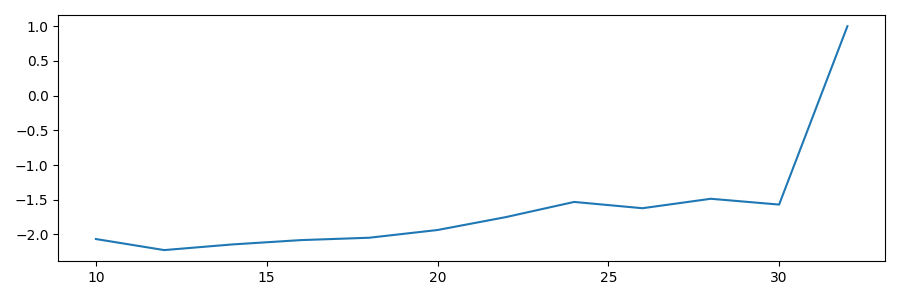

In [23]:
tlist, plist = [], range(10, 34, 2)
for npt in plist:
    s, t = solve_basic_problem(npt)
    tlist.append(t)
er.plot_scalability_evalulation(plist, np.log10(tlist), figsize=figsize)

## Considerations

**The world is not made of pure ML problems**

* For heavily constrained problems with a well understood structure
* ...Combinatorial optimization approaches can be a much better choice

**About the scary "intractable" thing**

* Yes, many practical combinatorial optimization problems are NP-hard, but
* ...All that matters is if you can solve _your problem size_
* ...High quality solutions can be obtained _way before_ optimality is proven

**This is not only about Emergency Rooms**

* Most production scheduling problems have more or less the same structure
* They are ubiquitous (in manufacturing) and often solved with poor approaches